In [45]:
# First things first, cue the song: UB40 - "Red Red Wine"
# This code is only here to check that your internet is enabled. It doesn't do anything else.

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [46]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
!pip install duckduckgo-search

In [47]:
# I probably don't need this here, but I'm just keeping it for now
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

In [48]:
# Import the DuckDuckGo search module and utilities from the fastcore library
# The 'search_images' function take two parameters: term (the search keyword), and max_images (the max # of images to find)
# then uses DuckDuckGo's image search to find images
# Returns the list of image URLs found

from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    with DDGS() as ddgs:
        return [r['image'] for r in ddgs.images(keywords=term, max_results=max_images)]

In [49]:
# Call the search_images function to search for 'red wine' and only get 1 image
# Urls will store the result, which is a list of image URLs.
# Then print the first URL from the list (since we only requested 1 image)

urls = search_images('red wine', max_images=1)
urls[0]

Searching for 'red wine'


'https://www.thespruceeats.com/thmb/_yDhAjE6dns0-D4Q8nx9FCS7GQI=/1553x1931/filters:fill(auto,1)/GettyImages-200157374-001-71e5fecc060c4651838a6308c3ef85e4.jpg'

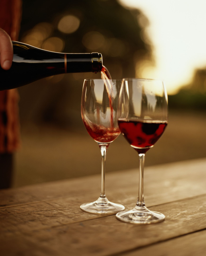

In [50]:
# Fastdownload imports a tool to download files from the internet
# It sets a destination filename, red-wine.jpg, where the image will be saved
# It then downloads the image from the first URL (urls[0]) and saves it as red-wine.jpg

# Fastai improts tools for working with images
# It opens the image file we just downloaded, red-wine.jpg
# Then it converts the img into a thumbnail

from fastdownload import download_url
dest = 'red-wine.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'white wine'


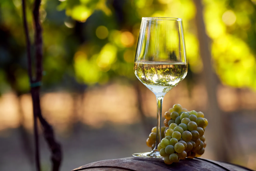

In [51]:
# First, we search for images related to white wine and returns 1 image. The URL(s) are stored in the variable urls.
# Checks if any URLs were found.
# Saves the image in the filename white-wine.jpg
# It opens the downloaded image file
# Displays the thumbnail
# If no images were found, it prints "no images found"

urls = search_images('white wine', max_images=1)

if urls:
    # Download the image
    dest = 'white-wine.jpg'  # Changed the filename to reflect the content
    download_url(urls[0], dest, show_progress=False)

    # Open and display the image
    im = Image.open(dest)
    display(im.to_thumb(256,256))
else:
    print("No images found.")

In [52]:
# A tuple called searchers is created and contains two strings: red wine and white wine
# the path is set to a folder named red wine or not
# Sleep function helps to add pauses between actions
# The loop goes through each item in the searches tuple
# Inside the loop, path/o are combined by creating a specific folder, where the images will be saved
# It then uses dest.mkdir to create the necessary folders to save the images if they don't already exist
# download_images function is called to download images related to the current search term
# sleep10 pauses the loop for 10 seconds. Helps to avoid overloading the server
# The images are resized to 400px

searches = 'red wine','white wine'
path = Path('red_wine_or_not')
print(os.getcwd())
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o}'))
    sleep(10)  # Pause between searches to avoid over-loading server
    resize_images(path/o, max_size=400, dest=path/o)

/content
Searching for 'red wine'
Searching for 'white wine'


In [53]:
# verify images check the validity of the images. The get_image_files(path) function retrieves a list of all images in that path
# failed.map takes any files that failed the verification and deletes them
# len(failed) retunds the number of failed files

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

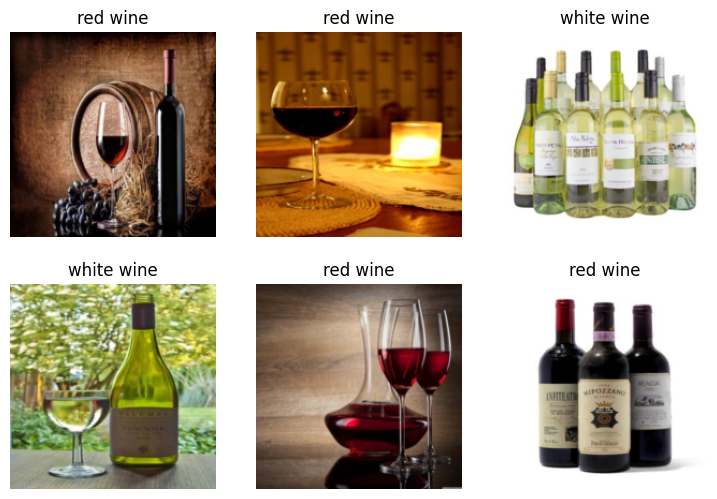

In [54]:
# DataBlock is a way to organize data for machine learning, via fastai
# blocks tells fastai that the input data are images (ImageBlock) and the labels or outputs are categories (CategoryBlock)
# get_items tells fastai to use get_image_files funtion to find all the image files in the path
# The splitter, splits the dataset into a training set (80%) and a validation set (20%)
# get_y function is used to get the labels for each item
# The item_tfms applies a transformation to each image and resizes them to 192x192 pixels, using the squish method
# Dataloaders is intialized, it handles how the data is loaded during training. bs=32 sets the batch size to 32 images
# dls.show_batch displays a batch of 6 images

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [55]:
# learn creates a ML model. vision_learner is used for working with images
# dls is the DataLoaders object that contains the images organized into training and validation sets
# resnet 18 is pre-trained neural network that has already learned to recognize many types of images
# metrics=error_rate sets the metric to track how well the model is doing
# the error rate tells us the percentage of incorrect predictions the model makes

# Then we fine tune the model to adjust itself over 3 cycles (epochs)


learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.801046,0.154823,0.053333,00:48


epoch,train_loss,valid_loss,error_rate,time
0,0.156667,0.269963,0.040000,01:14
1,0.103526,0.323492,0.040000,01:09
2,0.068993,0.278434,0.040000,01:10


In [56]:
# Now we make a prediction. learn.predict function runs the image through the model and tries to predict what the image is
# Then the variable stores the models prediction, is_red_wine
# probs stores the probabilities for each possible outcome

is_red_wine,_,probs = learn.predict(PILImage.create('red_wine.jpg'))
print(f"This is a: {is_red_wine}.")
print(f"Probability it's red wine: {probs[0]:.4f}")

This is a: red wine.
Probability it's red wine: 1.0000
